In [1]:
import scipy.io
import numpy as np
import scipy as sp
import cupy as cp
import matplotlib.pyplot as plt
import os
from SWE_utils_cupy_pipelined import *
from scipy.signal import firwin, butter, buttord, freqz

from arrus.ops.us4r import *
from arrus.ops.imaging import *
from arrus.metadata import *
from arrus.devices.probe import *
from arrus.devices.us4r import Us4RDTO
from arrus.utils.imaging import *

In [6]:
mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()    
print("Mempool used bytes: {:d}".format(mempool.used_bytes()))
print("Mempool total bytes: {:d}".format(mempool.total_bytes()))

Mempool used bytes: 0
Mempool total bytes: 0


In [7]:
! nvidia-smi

Wed May 10 17:36:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 306...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8    20W /  N/A |    382MiB /  5946MiB |     39%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [23]:
pb_focus_z = [15, 16] 
pwi_tx_angles = [-4, 0, 4]
pwi_frames = 40
    
last_idx = len(pb_focus_z) + pwi_frames * 2   
    
# Push beams
for i in range(len(pb_focus_z)):
    index = i
    next_ptr = i+1
    print((index, next_ptr))

seq_idx = len(pb_focus_z)

# PWI beams
print('PWI part')
pwi_idx = 0

while pwi_idx < pwi_frames:
    for i in range(len(pwi_tx_angles)):
        if(pwi_idx == pwi_frames):
            break
        else:
            print(pwi_tx_angles[i])
            index = seq_idx + 2*pwi_idx
            next_ptr = seq_idx + 2*pwi_idx + 1
            print((index, next_ptr))

            index = seq_idx + 2*pwi_idx + 1
            next_ptr = (seq_idx + 2*pwi_idx + 2) % last_idx
            print((index, next_ptr)) 

        pwi_idx = pwi_idx + 1
    

(0, 1)
(1, 2)
PWI part
-4
(2, 3)
(3, 4)
0
(4, 5)
(5, 6)
4
(6, 7)
(7, 8)
-4
(8, 9)
(9, 10)
0
(10, 11)
(11, 12)
4
(12, 13)
(13, 14)
-4
(14, 15)
(15, 16)
0
(16, 17)
(17, 18)
4
(18, 19)
(19, 20)
-4
(20, 21)
(21, 22)
0
(22, 23)
(23, 24)
4
(24, 25)
(25, 26)
-4
(26, 27)
(27, 28)
0
(28, 29)
(29, 30)
4
(30, 31)
(31, 32)
-4
(32, 33)
(33, 34)
0
(34, 35)
(35, 36)
4
(36, 37)
(37, 38)
-4
(38, 39)
(39, 40)
0
(40, 41)
(41, 42)
4
(42, 43)
(43, 44)
-4
(44, 45)
(45, 46)
0
(46, 47)
(47, 48)
4
(48, 49)
(49, 50)
-4
(50, 51)
(51, 52)
0
(52, 53)
(53, 54)
4
(54, 55)
(55, 56)
-4
(56, 57)
(57, 58)
0
(58, 59)
(59, 60)
4
(60, 61)
(61, 62)
-4
(62, 63)
(63, 64)
0
(64, 65)
(65, 66)
4
(66, 67)
(67, 68)
-4
(68, 69)
(69, 70)
0
(70, 71)
(71, 72)
4
(72, 73)
(73, 74)
-4
(74, 75)
(75, 76)
0
(76, 77)
(77, 78)
4
(78, 79)
(79, 80)
-4
(80, 81)
(81, 0)


In [2]:
! nvidia-smi

Wed May 10 17:15:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 306...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8    19W /  N/A |    376MiB /  5946MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Clear GPU memory
fft_plan_cache = cp.fft.config.get_plan_cache()
mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()  

fft_plan_cache.clear()
mempool.free_all_blocks()
pinned_mempool.free_all_blocks()

In [5]:
focus = np.array([15, 20, 25, 32, 35])  #[mm]
f = 1.75 # funmber
ap = np.ceil(focus / (f * 0.298))
max_shift = np.floor(63 - ap / 2)
print('Apertures:')
print(ap)
print('Max shifts:')
print(max_shift)

Apertures:
[29. 39. 48. 62. 68.]
Max shifts:
[48. 43. 39. 32. 29.]


In [69]:
kHz = np.array([6.25, 5.5, 5.0, 4.5, 4.0, 3.5, 3.0, 2.5, 2.0, 1.5, 1.0])
us = np.ceil(1000/kHz/2)
print(us)

[ 80.  91. 100. 112. 125. 143. 167. 200. 250. 334. 500.]


In [3]:
%matplotlib widget

### B-mode display

(200, 251)
(200, 251)


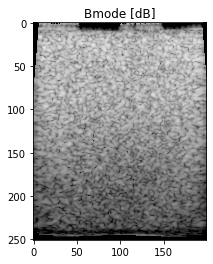

In [7]:
data = sp.io.loadmat("./Parametric_tests/Test_11/Bmode_pblen200.0_hv60_id_2.mat")
lri= data["data"]
print(lri.shape)
#lri = lri[5, :, :]
print(lri.shape)
lri = np.squeeze(lri)

if(1):
    #hri = np.mean(a=lri, axis=0)
    #hri = np.squeeze(lri[41, :, :])
    hri = lri

    # Envelope detection
    data = np.abs(hri)
    # Log compression
    data[data==0] = 10**-10
    data = 20 * np.log10(data)

    data_dim = data.shape
    if(data_dim[1] > data_dim[0] ):
        data = np.transpose(data, [1,0])

    dB_range = [20, 84] 
    norm = plt.Normalize(dB_range[0], dB_range[1], True)
    fig, ax0 = plt.subplots(1, 1, figsize=(8, 4))
    #%matplotlib widget
    ax0.imshow(data, cmap='gray', norm=norm)
    ax0.set_title('Bmode [dB]')

# Shear wave motion data

(250, 200, 115)


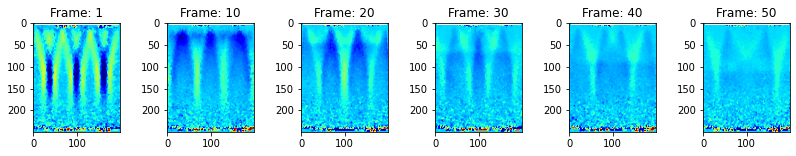

In [12]:
data1 = sp.io.loadmat("./Parametric_tests/Test_11/swd_pblen200.0_hv40_id_3.mat")
#data1 = sp.io.loadmat("/media/damian/8A4F-A24E/Results/Test_3/swd_pbfreq4.0_foc25.0_pblen250.0_pbAp48_id_0.mat")
ddata1_cpu= data1["data"]
#data2 = sp.io.loadmat("./Parametric_tests/Test_2/a/swd_freq6.0_cycles2_pri100.0_id_0.mat")
#ddata2_cpu= data2["data"]

print(ddata1_cpu.shape)

#getHistogram(data=ddata_cpu, Vrange = [-0.5e-3, 0.5e-3])
DrawShearWaveFrames(data=ddata1_cpu, Vrange=[-1.5e-3, 3e-3], frames=[1, 10, 20, 30, 40, 50])
#DrawShearWaveFrames(data=ddata2_cpu, Vrange=[-1.5e-3, 3e-3], frames=[1, 4, 7, 10, 13, 16])


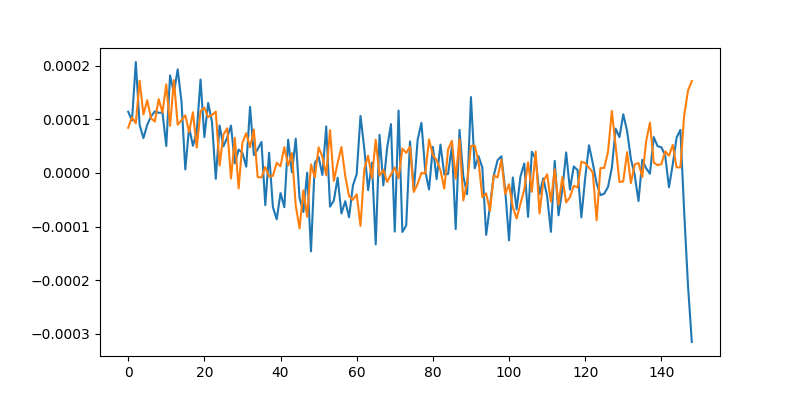

In [60]:
# Plot some profiles
%matplotlib widget
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(np.squeeze(ddata_cpu[100, 150-15, :]))
ax.plot(np.squeeze(ddata_cpu[100, 150+15, :]))

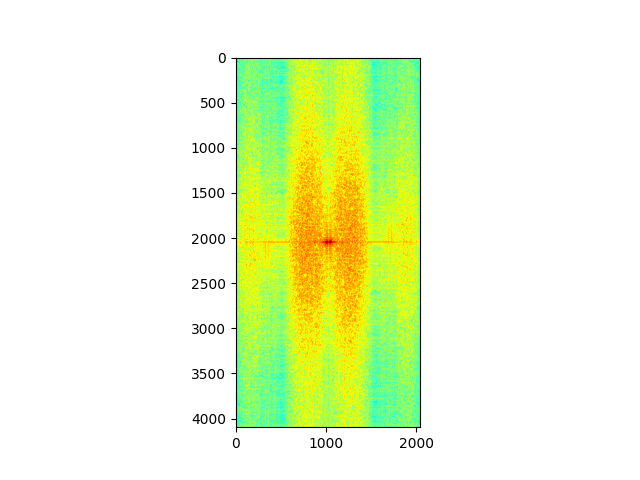

In [6]:
## Get spatio-temporal (sliced) frequency spectrum
depth_limits = [100, 110]
NFFT = [4096, 2048]
slice_in = ddata_cpu[depth_limits[0]:depth_limits[1], :, :]

def SW_spectralAnalysis_SpatioTemporal(data, depth_limits, NFFT):

    # Averaging data along axial dimension
    slice_in = np.squeeze(np.mean(data, axis=0))

    # Do FFT2
    slice_k = sp.fft.fft2(slice_in, s=NFFT)
    slice_k = sp.fft.fftshift(slice_k)

    # Normalize
    X = np.abs(slice_k)
    MaxX = np.max(X.flatten())
    Xn = X/MaxX
    
    # Log compression
    img = 20 * np.log10(Xn)
    return img

img = SW_spectralAnalysis_SpatioTemporal(data=slice_in, depth_limits=depth_limits, NFFT=NFFT)

## Results presentation ##
##  Spectral data
%matplotlib widget
plt.figure()
plt.clf()
plt.imshow(img+6.5, cmap='jet')
    


In [ ]:
# Obtain freq
x = 1280
fs = 5000
NFFT_f = NFFT[1]
xr = x - NFFT_f/2
f = xr * fs/NFFT_f
print(f)

In [ ]:
## Results presentation ##
## Motion data slice
px_size=0.2 #[mm]
pri = 0.2 #[ms]
tick_grid_size=[5, 5] #[ms, mm]

plt.figure()
plt.clf()
plt.imshow(slice_in, cmap='gray')
plt.title('Spatio-temporal motion data slice')
plt.xlabel("Slow-time [ms]")
plt.ylabel("x [mm]")

# Assign ticks
dim = slice_in.shape
y_grid = tick_grid_size[1]  #[mm]
x_grid = tick_grid_size[0]  #[mm]

m = int(dim[0]//2)
a = np.arange(m, 0, -int(np.ceil(x_grid / px_size)))
b = np.arange(m, dim[0]-1, int(np.ceil(x_grid / px_size)))
yticks = np.concatenate((a[1:], b))
yticks_labels = (yticks - m) * px_size
yticks_labels = [str(int(x)) for x in yticks_labels]
plt.yticks(yticks, yticks_labels)

xticks  = np.arange(0, dim[1]-1, int(np.ceil(x_grid / pri))) 
xticks_labels = xticks * pri
xticks_labels = [str(int(x)) for x in xticks_labels]
plt.xticks(xticks, xticks_labels)


In [ ]:
## Get temporal frequency spectrum

data = ddata_cpu[85:125, 100:150, :]
print(data.shape)
Fs = 1/200e-6
NFFT = 2048

def SW_spectralAnalysis_Temporal(data, Fs, NFFT):

    # Apply window function
    N = data.shape[2]
    w = sp.signal.windows.tukey(N, alpha=0.2, sym=True)
    data_w = data * w

    # Do fft
    Hy = sp.fft.fft(data_w, NFFT)
    P2 = np.abs(Hy/NFFT)
    P1 = P2[:, :, 1:NFFT//2+1]
    P1[:, :, 1:-1] = 2*P1[:, :, 1:-1]

    # Average
    Pmean = np.mean(P1, axis=0)
    Pmean = np.mean(Pmean, axis=0)

    #Plot
    x_f = np.arange(0, NFFT//2, 1)
    x_f = Fs*x_f/NFFT

    M = np.max(Pmean)
    Xn = Pmean/M
    Pmean_dB = 20 * np.log10(Xn)
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.plot(x_f, Pmean_dB+3.5)
    return

SW_spectralAnalysis_Temporal(data=data, Fs=Fs, NFFT=NFFT)


## Post shear wave motion filtering data

(2, 250, 200, 145)
float32


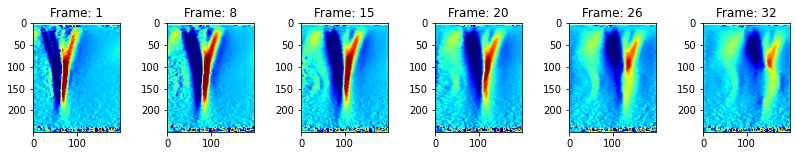

In [29]:
data = sp.io.loadmat("./Parametric_tests/Test_10/swdf_id_5.mat")
ddata_cpu= data["data"]
print(ddata_cpu.shape)
print(ddata_cpu.dtype)

DrawShearWaveFrames(data=np.squeeze(ddata_cpu[0, ...]), Vrange=[-1e-3, 2e-3], frames=[1, 8, 15, 20, 26, 32])

In [ ]:
# Plot some profiles
%matplotlib widget
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(np.squeeze(ddata_cpu[0, 100, 150-15, :]))
ax.plot(np.squeeze(ddata_cpu[0, 100, 150+15, :]))

In [ ]:
## Get energy map
ddataE = np.squeeze(ddata_cpu[0, 10:-20, ...])

# Get avarage and delete it
m = np.mean(ddataE, axis=2)
ddataE = np.transpose(ddataE, [2,0,1])
ddataE = np.subtract(ddataE, m)
ddataE = np.transpose(ddataE, [1,2,0])
E = np.power(ddataE, 2)
E = np.squeeze(np.sum(E, 2))
E = np.sqrt(E)

norm = plt.Normalize(0, 0.002, True)
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
print(E.shape)
ax.imshow(E, cmap='jet', norm=norm)

        

## Energy maps

(220, 200)
float32
(220, 200)


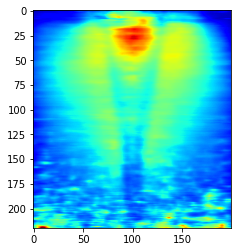

In [6]:
# Display energy map
data = sp.io.loadmat("./Parametric_tests/Test_8/energy_swdf_id_0.mat")
energy= data["data"]
print(energy.shape)
print(energy.dtype)

E = np.sqrt(energy)
norm = plt.Normalize(0, 0.005, True)
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
print(E.shape)
ax.imshow(E, cmap='jet', norm=norm)



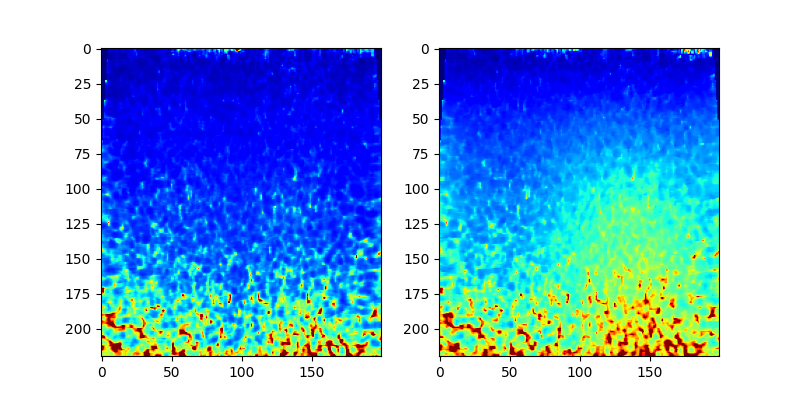

In [79]:
# Compare energy maps
data = sp.io.loadmat("./Parametric_tests/Test_1/d/energy_swd_freq4.4_cycles2_pri100.0_id_0.mat")
energy1= data["data"]

data = sp.io.loadmat("./Parametric_tests/Test_1/d/energy_swd_freq4.4_cycles2_pri500.0_id_0.mat")
energy2= data["data"]

E1 = np.sqrt(energy1)
E2 = np.sqrt(energy2)
norm = plt.Normalize(0, 0.005, True)
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(E1, cmap='jet', norm=norm)
ax2.imshow(E2, cmap='jet', norm=norm)

## SWS data

In [20]:
data = sp.io.loadmat("./Parametric_tests/Test_11/sws_pblen200.0_hv40_id_3.mat")
SWV_cpu= data["data"]
print(SWV_cpu.shape)
print(SWV_cpu.dtype)


(2, 2, 250, 200)
float32


Text(0.5, 1.0, 'r_RL')

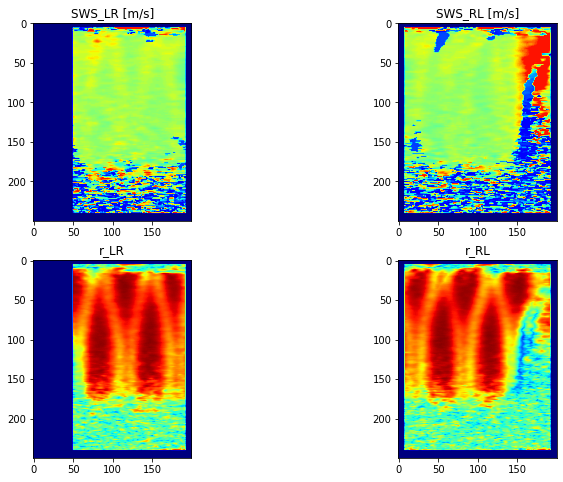

In [21]:
#Visualize the results (pre-compounding)
SWS_cpu = np.squeeze(SWV_cpu[0, ...])
SWS_r_cpu = np.squeeze(SWV_cpu[1, ...])
print()
norm_sws = plt.Normalize(0, 4.5, True)
norm_r   = plt.Normalize(0, 1, True)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axs[0,0].imshow(np.squeeze(SWS_cpu[0,:,:]), cmap='jet', norm=norm_sws)
axs[0,0].set_title('SWS_LR [m/s]')

axs[1,0].imshow(np.squeeze(SWS_r_cpu[0,:,:]), cmap='jet', norm=norm_r)
axs[1,0].set_title('r_LR')

axs[0,1].imshow(np.squeeze(SWS_cpu[1,:,:]), cmap='jet', norm=norm_sws)
axs[0,1].set_title('SWS_RL [m/s]')

axs[1,1].imshow(np.squeeze(SWS_r_cpu[1,:,:]), cmap='jet', norm=norm_r)
axs[1,1].set_title('r_RL')

In [ ]:
#Visualize the results (post-compounding)
SWS_cpu = np.squeeze(SWV_cpu[0, ...])
SWS_r_cpu = np.squeeze(SWV_cpu[1, ...])
print()
sws_range = [0.5, 4.0]
norm_sws = plt.Normalize(0, 5.0, True)
norm_r   = plt.Normalize(0, 2, True)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
axs[0].imshow(np.squeeze(SWS_cpu), cmap='jet', norm=norm_sws)
axs[0].set_title('SWS_LR [m/s]')

axs[1].imshow(np.squeeze(SWS_r_cpu), cmap='jet', norm=norm_r)
axs[1].set_title('r_LR')


# Post-processing

## Image compounding

In [ ]:
# Visualize results
SWSc_cpu  = SWSc.get()
SWS = np.squeeze(SWSc_cpu[0])
r   = np.squeeze(SWSc_cpu[1])
norm_r   = plt.Normalize(0, 2, True)
norm_sws = plt.Normalize(swse_SWV_range[0], swse_SWV_range[1], True)
norm_sws = plt.Normalize(0, 5, True)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))
axs[0].imshow(np.squeeze(SWS), cmap='jet', norm=norm_sws)
axs[0].set_title('SWSc [m/s]')

axs[1].imshow(np.squeeze(r), cmap='jet', norm=norm_r)
axs[1].set_title('r [m/s]')

## Image filtering

In [ ]:
# Visualize results
SWSc_cpu  = SWSc.get()
SWS = np.squeeze(SWSc_cpu[0])
r   = np.squeeze(SWSc_cpu[1])
norm_r   = plt.Normalize(0, 2, True)
norm_sws = plt.Normalize(swse_SWV_range[0], swse_SWV_range[1], True)
norm_sws = plt.Normalize(0, 5, True)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))
axs[0].imshow(np.squeeze(SWS), cmap='jet', norm=norm_sws)
axs[0].set_title('SWSc [m/s]')

axs[1].imshow(np.squeeze(r), cmap='jet', norm=norm_r)
axs[1].set_title('r [m/s]')

## Data presentation

In [ ]:
# Get data from GPU
SWSc_cpu  = SWSc.get()
SWS = np.squeeze(SWSc_cpu[0])
r   = np.squeeze(SWSc_cpu[1])

In [ ]:
# Visualize SWS map
plotSWSmap(data=SWS[swse_z_clip[0]:-swse_z_clip[1], swse_d//2:-swse_d//2], px_size=px_size, tick_grid_size=[5, 5], sws_disp_range=[0, 5])
plotSWSmap(data=r[swse_z_clip[0]:-swse_z_clip[1], swse_d//2:-swse_d//2], px_size=px_size, tick_grid_size=[5, 5], sws_disp_range=[0, 2])